In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser

importing Jupyter notebook from imagePreProcessor.ipynb


2023-06-20 10:25:31.231881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel'

In [3]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset/')

In [4]:
df = pd.read_csv("tesseract.csv")

In [5]:
df.shape

(155, 30)

In [6]:
df.describe()

,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,PageWidth,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,77.000000,765.516129,789.277419,169.283871,25.541935,73.489993,931.651613,816.600000,2368.432258,1798.819355,...,0.107489,0.018736,0.035820,0.005642,0.032175,0.086455,0.026026,0.007131,0.003957,0.438710
std,44.888751,499.093729,590.108459,126.413450,9.725611,26.377241,504.201601,589.678898,423.793965,261.785638,...,0.151895,0.073313,0.138703,0.035210,0.096474,0.181889,0.094436,0.039630,0.025152,0.497838
min,0.000000,9.000000,44.000000,66.000000,13.000000,0.000000,107.000000,65.000000,319.000000,1653.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.500000,277.000000,350.500000,112.500000,20.000000,64.098629,435.500000,376.000000,2200.000000,1654.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77.000000,745.000000,561.000000,132.000000,23.000000,83.262383,879.000000,595.000000,2338.000000,1700.000000,...,0.042007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,115.500000,1232.500000,1057.000000,164.500000,26.000000,93.271563,1407.500000,1086.500000,2339.000000,1700.000000,...,0.159750,0.000000,0.000000,0.000000,0.000000,0.052856,0.000000,0.000000,0.000000,1.000000
max,154.000000,2043.000000,2876.000000,1029.000000,76.000000,96.851837,2167.000000,2906.000000,3312.000000,2342.000000,...,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [7]:
len(df["imageName"].unique())

44

In [8]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        text = df["text"][index]
        date = list(datefinder.find_dates(text))[0]
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y<Y:
            df["isBottom"][index]=1
        elif y>Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth", "conf", "isPast", "isFuture"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [9]:
preProcess(df)

/tmp/ipykernel_8036/413941093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_8036/413941093.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_8036/413941093.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_8036/413941093.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [10]:
df

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,0.275091,0.482257,0,1,0,1,0.541396,0.0,0.494869,0.0,0.151753,0.000000,0.000000,0.528837,0.0,0.0,0.0,0
1,0.927449,0.499786,0,1,1,0,0.111245,0.0,0.157799,0.0,0.804302,0.000000,0.000000,0.131721,0.0,0.0,0.0,1
2,0.591898,0.791364,1,0,1,0,0.120358,0.0,0.184538,0.0,0.000000,0.000000,0.162403,0.421051,0.0,0.0,0.0,0
3,0.591898,0.821719,1,0,1,0,0.116690,0.0,0.159205,0.0,0.000000,0.000000,0.132623,0.000000,0.0,0.0,0.0,0
4,0.906892,0.499786,0,1,1,0,0.090689,0.0,0.137243,0.0,0.783751,0.000000,0.000000,0.112152,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,0.878235,0.246818,0,1,1,0,0.000000,0.0,0.366004,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
151,0.512402,0.177426,0,1,1,0,0.081065,0.0,0.124913,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
152,0.878403,0.471997,0,1,1,0,0.031390,0.0,0.423249,0.0,0.283171,0.021537,0.042880,0.000000,0.0,0.0,0.0,0
153,0.502722,0.177426,0,1,1,0,0.071385,0.0,0.116018,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1


In [11]:
df.describe()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.532983,0.347971,0.219355,0.780645,0.535484,0.464516,0.042810,0.003847,0.107489,0.018736,0.035820,0.005642,0.032175,0.086455,0.026026,0.007131,0.003957,0.438710
std,0.290380,0.254272,0.415151,0.415151,0.500356,0.500356,0.079587,0.017137,0.151895,0.073313,0.138703,0.035210,0.096474,0.181889,0.094436,0.039630,0.025152,0.497838
min,0.045766,0.019626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250840,0.170909,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.512402,0.264643,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.042007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.836106,0.472362,0.000000,1.000000,1.000000,1.000000,0.065370,0.000000,0.159750,0.000000,0.000000,0.000000,0.000000,0.052856,0.000000,0.000000,0.000000,1.000000
max,0.927449,1.865204,1.000000,1.000000,1.000000,1.000000,0.541396,0.098908,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [12]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.350075,-0.423006,0.423006,0.919649,-0.919649,-0.132294,0.199715,0.377749,0.139393,0.280323,-0.017448,0.234892,-0.176389,0.109567,0.073719,-0.161609,0.263104
y,-0.350075,1.000000,0.776300,-0.776300,-0.285656,0.285656,-0.008167,-0.199675,-0.182619,-0.001541,0.052022,-0.048771,0.019787,0.272592,-0.119615,0.148240,-0.124837,-0.439892
isTop,-0.423006,0.776300,1.000000,-1.000000,-0.381578,0.381578,-0.005333,-0.119368,-0.202707,-0.091951,-0.137340,-0.085216,-0.129529,0.427513,-0.122839,-0.002309,-0.083674,-0.374387
isBottom,0.423006,-0.776300,-1.000000,1.000000,0.381578,-0.381578,0.005333,0.119368,0.202707,0.091951,0.137340,0.085216,0.129529,-0.427513,0.122839,0.002309,0.083674,0.374387
isRight,0.919649,-0.285656,-0.381578,0.381578,1.000000,-1.000000,-0.134976,0.209734,0.315289,0.102929,0.218943,-0.058293,0.216997,-0.153615,0.077334,0.090656,-0.169479,0.223851
isLeft,-0.919649,0.285656,0.381578,-0.381578,-1.000000,1.000000,0.134976,-0.209734,-0.315289,-0.102929,-0.218943,0.058293,-0.216997,0.153615,-0.077334,-0.090656,0.169479,-0.223851
date,-0.132294,-0.008167,-0.005333,0.005333,-0.134976,0.134976,1.000000,-0.121520,0.220897,0.020330,0.039624,0.242075,-0.036460,0.227542,-0.004684,-0.044812,0.175147,0.015555
dated,0.199715,-0.199675,-0.119368,0.119368,0.209734,-0.209734,-0.121520,1.000000,0.286082,0.193907,0.016713,-0.036201,-0.025188,-0.107381,0.294882,-0.040652,-0.035545,0.131972
invoice,0.377749,-0.182619,-0.202707,0.202707,0.315289,-0.315289,0.220897,0.286082,1.000000,0.245127,0.040305,0.088596,-0.093071,0.071651,0.091598,-0.089067,-0.112064,0.070009
delivery,0.139393,-0.001541,-0.091951,0.091951,0.102929,-0.102929,0.020330,0.193907,0.245127,1.000000,-0.027173,-0.041217,0.027026,-0.004514,0.302819,0.062665,-0.040470,0.011862


In [13]:
df.shape

(155, 18)

In [14]:
len(df[df["output"]==0])

87

In [15]:
len(df[df["output"]==1])

68

In [16]:
dfTrue = df[df["output"]==1].sample(frac=1)[:65]
dfFalse = df[df["output"]==0].sample(frac=1)[:65]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df


,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
103,0.196007,0.147499,0,1,0,1,0.096794,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
74,0.808832,0.220607,0,1,1,0,0.000000,0.0,0.117967,0.0,0.0,0.000000,0.000000,0.176649,0.0,0.0,0.0,1
102,0.797647,0.098182,0,1,1,0,0.157648,0.0,0.196471,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
113,0.700726,0.601112,1,0,1,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
104,0.179068,0.147499,0,1,0,1,0.079855,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.082514,0.964933,1,0,0,1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
26,0.785882,0.419091,0,1,1,0,0.000000,0.0,0.000000,0.0,0.0,0.133529,0.164133,0.000000,0.0,0.0,0.0,0
127,0.205082,0.248397,0,1,0,1,0.000000,0.0,0.099664,0.0,0.0,0.000000,0.088505,0.000000,0.0,0.0,0.0,0
13,0.303529,0.239091,0,1,0,1,0.187059,0.0,0.228390,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1


In [17]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.332515,-0.393465,0.393465,0.925867,-0.925867,-0.147351,0.216582,0.401188,0.132321,0.260037,-0.022040,0.227577,-0.180608,0.116523,0.078096,-0.180782,0.239529
y,-0.332515,1.000000,0.764410,-0.764410,-0.250124,0.250124,-0.011814,-0.203545,-0.176435,0.022310,0.035913,-0.040488,0.024987,0.290153,-0.111576,0.180815,-0.125470,-0.426816
isTop,-0.393465,0.764410,1.000000,-1.000000,-0.331286,0.331286,-0.001368,-0.120570,-0.199506,-0.078885,-0.128765,-0.085867,-0.098960,0.450699,-0.118829,0.010915,-0.084305,-0.370842
isBottom,0.393465,-0.764410,-1.000000,1.000000,0.331286,-0.331286,0.001368,0.120570,0.199506,0.078885,0.128765,0.085867,0.098960,-0.450699,0.118829,-0.010915,0.084305,0.370842
isRight,0.925867,-0.250124,-0.331286,0.331286,1.000000,-1.000000,-0.170937,0.228765,0.340020,0.095984,0.211908,-0.064890,0.226948,-0.145722,0.079164,0.098165,-0.186618,0.216025
isLeft,-0.925867,0.250124,0.331286,-0.331286,-1.000000,1.000000,0.170937,-0.228765,-0.340020,-0.095984,-0.211908,0.064890,-0.226948,0.145722,-0.079164,-0.098165,0.186618,-0.216025
date,-0.147351,-0.011814,-0.001368,0.001368,-0.170937,0.170937,1.000000,-0.131038,0.240065,0.003810,0.051637,0.252660,-0.017924,0.245033,-0.006123,-0.049477,0.182261,0.013113
dated,0.216582,-0.203545,-0.120570,0.120570,0.228765,-0.228765,-0.131038,1.000000,0.288287,0.191231,0.034831,-0.043483,-0.022620,-0.112808,0.287496,-0.048861,-0.042692,0.113431
invoice,0.401188,-0.176435,-0.199506,0.199506,0.340020,-0.340020,0.240065,0.288287,1.000000,0.244304,0.074180,0.084988,-0.084423,0.125099,0.086521,-0.100828,-0.123664,0.043811
delivery,0.132321,0.022310,-0.078885,0.078885,0.095984,-0.095984,0.003810,0.191231,0.244304,1.000000,-0.017437,-0.046929,0.022178,0.012566,0.301204,0.058395,-0.046075,-0.003843


In [18]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [19]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [20]:
xTrain.shape

(104, 17)

In [21]:
xTest.shape

(26, 17)

In [22]:
yTrain.shape

(104,)

In [30]:
yTest.shape

(26,)

In [87]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [123]:
xgb = XGBClassifier(max_depth=10, learning_rate=0.1, reg_alpha = 0.5, reg_lambda = 0.5, num_parallel_tree = 10, objective = "binary:hinge", eval_metric = "error")

In [124]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=10,
              objective='binary:hinge', predictor=None, ...)

In [125]:
pred = xgb.predict(xTest)
pred

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0])

In [126]:
yTest

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0])

In [127]:
acc = accuracy_score(pred, yTest)
acc

0.9230769230769231

In [55]:
X = [x[0] for x in xTest]

In [56]:
len(X)

26

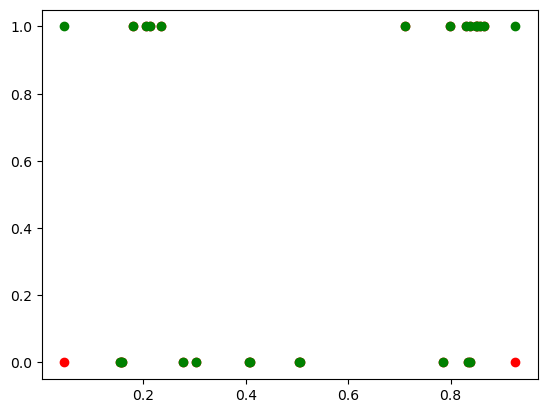

In [60]:
plt.scatter(X, pred, color="red")
plt.scatter(X, yTest, color="green")
plt.show()

In [128]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset'

In [130]:
xgb.save_model("/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Models/InvoiceDateXGBoost.json")